Columns in .FIT file: ['activity_type', 'cadence', 'distance', 'enhanced_altitude', 'enhanced_speed', 'fractional_cadence', 'heart_rate', 'position_lat', 'position_long', 'stance_time', 'stance_time_balance', 'stance_time_percent', 'step_length', 'temperature', 'timestamp', 'vertical_oscillation', 'vertical_ratio', 'unknown_107', 'unknown_134', 'unknown_135', 'unknown_136', 'unknown_137', 'unknown_138', 'unknown_140', 'unknown_143', 'unknown_144', 'unknown_87', 'unknown_108', 'unknown_90']
Detected Hill Repeats:
            start_time            end_time  elevation_gain  distance
0  2024-12-05 06:33:46 2024-12-05 06:34:41            23.6     69.65
1  2024-12-05 06:35:18 2024-12-05 06:36:08            23.6     68.23
2  2024-12-05 06:36:46 2024-12-05 06:37:41            23.0     63.48
3  2024-12-05 06:38:18 2024-12-05 06:39:09            22.4     68.10
4  2024-12-05 06:39:47 2024-12-05 06:40:40            22.8     64.11
5  2024-12-05 06:41:18 2024-12-05 06:42:08            23.4     66.78

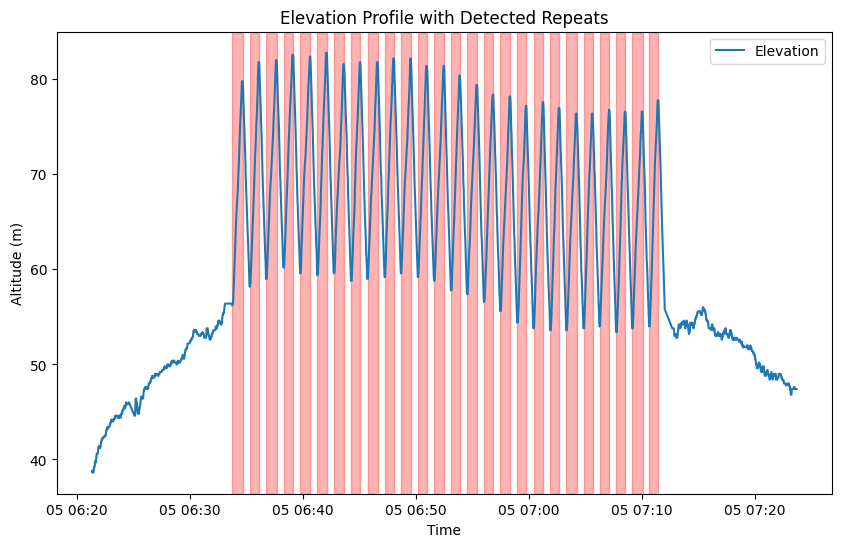

In [1]:
import fitparse
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Parse the .FIT file
def parse_fit_file(file_path):
    fitfile = fitparse.FitFile(file_path)
    data = []

    for record in fitfile.get_messages("record"):
        record_data = {}
        for field in record:
            record_data[field.name] = field.value
        data.append(record_data)

    df = pd.DataFrame(data)
    
    # Print a summary of the columns to understand structure
    print("Columns in .FIT file:", df.columns.tolist())
    
    # Clean and filter necessary columns
    required_columns = ["timestamp", "enhanced_altitude", "distance"]  # Modify if needed
    for col in required_columns:
        if col not in df.columns:
            print(f"Column '{col}' is missing in the data!")
            return None  # Early exit if required data is unavailable

    # Ensure relevant columns are present and processable
    df = df[required_columns].dropna()
    df["timestamp"] = pd.to_datetime(df["timestamp"])
    return df

# Detect hill repeats
def detect_repeats(df, elevation_gain_threshold=10, min_repeat_distance=50):
    df["alt_diff"] = df["enhanced_altitude"].diff()
    df["dist_diff"] = df["distance"].diff()

    # Detect uphill segments
    df["is_uphill"] = df["alt_diff"] >= 0

    repeats = []
    current_repeat = []

    for i, row in df.iterrows():
        if row["is_uphill"]:
            current_repeat.append(row)
        else:
            if current_repeat:
                total_gain = sum(r["alt_diff"] for r in current_repeat if r["alt_diff"] >= 0)
                total_distance = sum(r["dist_diff"] for r in current_repeat if r["dist_diff"] >= 0)
                if total_gain >= elevation_gain_threshold and total_distance >= min_repeat_distance:
                    repeats.append({
                        "start_time": current_repeat[0]["timestamp"],
                        "end_time": current_repeat[-1]["timestamp"],
                        "elevation_gain": total_gain,
                        "distance": total_distance,
                    })
                current_repeat = []

    return pd.DataFrame(repeats)

# Plot repeats
def plot_repeats(df, repeats):
    plt.figure(figsize=(10, 6))
    plt.plot(df["timestamp"], df["enhanced_altitude"], label="Elevation")
    for _, repeat in repeats.iterrows():
        plt.axvspan(repeat["start_time"], repeat["end_time"], color='red', alpha=0.3)
    plt.title("Elevation Profile with Detected Repeats")
    plt.xlabel("Time")
    plt.ylabel("Altitude (m)")
    plt.legend()
    plt.show()

# File path
fit_file_path = "./fitfiles/17692097071_ACTIVITY.fit"  # Replace with actual file path

# Parse the FIT file
activity_data = parse_fit_file(fit_file_path)

if activity_data is not None:
    # Detect repeats
    repeats = detect_repeats(activity_data)
    print("Detected Hill Repeats:")
    print(repeats)

    # Optional: Plot elevation profile with repeats highlighted
    plot_repeats(activity_data, repeats)
else:
    print("The FIT file could not be processed. Check the columns and data.")
